In [53]:
import warnings
warnings.filterwarnings('ignore')

import requests
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
import seaborn as sns
from talib import WMA
from tqdm import tqdm
from scipy.stats import mstats
from scipy.signal import argrelextrema
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import math
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import SelectKBest, f_regression
from itertools import combinations
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

import calc_functions as u
import feature_generation as fg

# Set random seed
np.random.seed(0)
tf.random.set_seed(0)


## This notebook aims to generate WorldQuant's 101 alphas and use it as features for our ML model
    

>“An alpha is a combination of mathematical expressions, computer source code, and configuration parameters
> that can be used, in combination with historical data, to make predictions about future movements of various
> financial instruments"

[Finding Alphas: A Quantitative Approach to Building Trading Strategies](https://books.google.com/books?hl=en&lr=&id=ntuuDwAAQBAJ&oi=fnd&pg=PR11&dq=Finding+Alphas:+A+Quantitative+Approach+to+Building+Trading+Strategies&ots=nQrqbJlQu1&sig=FWfLI0_AIJWiNJ3D6tE0twHjj5I#v=onepage&q=Finding%20Alphas%3A%20A%20Quantitative%20Approach%20to%20Building%20Trading%20Strategies&f=false), Igor Tulchinsky, 2019

## Get data from binance

In [54]:
# LIST OF BINANCE URLS AVAIL
# GET /api/v3/klines
# GET /api/v3/uiKlines
# <symbol>@miniTicker
# <symbol>@ticker

# data format for reference
# [
#   [
#     1499040000000,      // Kline open time
#     "0.01634790",       // Open price
#     "0.80000000",       // High price
#     "0.01575800",       // Low price
#     "0.01577100",       // Close price
#     "148976.11427815",  // Volume
#     1499644799999,      // Kline Close time
#     "2434.19055334",    // Quote asset volume
#     308,                // Number of trades
#     "1756.87402397",    // Taker buy base asset volume
#     "28.46694368",      // Taker buy quote asset volume
#     "0"                 // Unused field, ignore.
#   ]
# ]

base_url = "https://api.binance.com/api/v3/klines"

# Function to fetch hourly data from Binance
def fetch_binance_data(symbol, interval, start_time, end_time):
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': int(start_time.timestamp() * 1000),
        'endTime': int(end_time.timestamp() * 1000),
    }
    response = requests.get(base_url, params=params)
    data = response.json()
    return data

# Function to convert Binance data to DataFrame
def binance_data_to_dataframe(data):
    # From klines in binance API
    df = pd.DataFrame(data, columns=['Open Time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close Time', 
                                     'Quote Asset Volume', 'Number of Trades', 'Taker Buy Base Asset Volume', 
                                     'Taker Buy Quote Asset Volume', 'Ignore'])
    
    # Convert timestamp to datetime
    df['Open Time'] = pd.to_datetime(df['Open Time'], unit='ms')
    df['Close Time'] = pd.to_datetime(df['Close Time'], unit='ms')
    # remove IGNORE column 
    df = df.drop(columns=['Ignore'])
    return df

# Parameters set
symbol = "BTCUSDT"
interval = "1d"
end_time = datetime.now()
start_time = end_time - relativedelta(months=60)  # 3 months ago, either this or 90 days

btcusdt_data = pd.DataFrame()

# There is a limit of 500 fetches per query, hence I used a loop to fetch data for past 3 months
while start_time < end_time:
    fetched_data = fetch_binance_data(symbol, interval, start_time, end_time)
    
    df = binance_data_to_dataframe(fetched_data)

    if not df.empty:
        btcusdt_data = pd.concat([btcusdt_data, df])
        start_time = pd.to_datetime(df['Close Time'].iloc[-1]) + timedelta(hours=1)
    else:
        break
        
btcusdt_data = btcusdt_data.reset_index(drop=True)
btcusdt_data = btcusdt_data.drop(columns=['Close Time'])
btcusdt_data.to_csv('./BTCUSDT_Hourly.csv', index=True) 

columns_to_convert = {
    'Open': float,
    'High': float,
    'Low': float,
    'Close': float,
    'Volume': float,
    'Quote Asset Volume': float,
    'Number of Trades': int,
    'Taker Buy Base Asset Volume': float,
    'Taker Buy Quote Asset Volume': float
}

btcusdt_data = btcusdt_data.astype(columns_to_convert)
btcusdt_data = btcusdt_data.set_index(['Open Time'])
btcusdt_data

,Open,High,Low,Close,Volume,Quote Asset Volume,Number of Trades,Taker Buy Base Asset Volume,Taker Buy Quote Asset Volume
Open Time,,,,,,,,,
2018-12-20,3660.01,4120.00,3635.00,4049.62,101543.835986,3.999671e+08,500506,52772.933168,2.078037e+08
2018-12-21,4051.86,4139.99,3764.00,3838.66,82343.850112,3.258033e+08,436187,41365.888997,1.637306e+08
2018-12-22,3840.25,3979.00,3785.00,3948.91,42822.350872,1.650856e+08,249148,22602.324084,8.715824e+07
2018-12-23,3948.91,4021.53,3870.00,3929.71,40117.531529,1.587564e+08,258417,20216.880715,8.003402e+07
2018-12-24,3929.71,4198.00,3924.83,4008.01,64647.809129,2.646290e+08,400403,33124.508698,1.356455e+08
...,...,...,...,...,...,...,...,...,...
2023-12-15,43022.26,43080.81,41666.00,41940.30,33421.793200,1.416899e+09,1323628,16321.136540,6.917133e+08
2023-12-16,41940.29,42724.43,41605.00,42278.03,24118.857470,1.020470e+09,1180886,12193.505110,5.159094e+08
2023-12-17,42278.02,42424.07,41252.00,41374.65,27722.114520,1.161964e+09,1227634,13245.864040,5.553093e+08


In [55]:
df = btcusdt_data[btcusdt_data.columns[:5]]
df.columns = df.columns.str.lower()
df['vwap'] = u.vwap(df)
df['returns'] = u.returns(df)
df = df.dropna()
df

,open,high,low,close,volume,vwap,returns
Open Time,,,,,,,
2018-12-21,4051.86,4139.99,3764.00,3838.66,82343.850112,3838.66,-0.052094
2018-12-22,3840.25,3979.00,3785.00,3948.91,42822.350872,3948.91,0.028721
2018-12-23,3948.91,4021.53,3870.00,3929.71,40117.531529,3929.71,-0.004862
2018-12-24,3929.71,4198.00,3924.83,4008.01,64647.809129,4008.01,0.019925
2018-12-25,4010.11,4020.00,3646.41,3745.79,62725.629432,3745.79,-0.065424
...,...,...,...,...,...,...,...
2023-12-15,43022.26,43080.81,41666.00,41940.30,33421.793200,41940.30,-0.025149
2023-12-16,41940.29,42724.43,41605.00,42278.03,24118.857470,42278.03,0.008053
2023-12-17,42278.02,42424.07,41252.00,41374.65,27722.114520,41374.65,-0.021368


In [56]:
unavailable = {48, 56, 58, 59, 63, 67, 69, 70, 76, 79, 80, 82, 87, 89, 90, 91, 93, 97, 100}

for n in tqdm(range(101), desc="Processing Alphas"):
    if n+1 in unavailable:
        pass
    else:
        name = 'alpha{}'.format(n+1)
        func = 'fg.{}'.format(name)
        temp_func = eval(func)
        df[name] = temp_func(df)
df = df.dropna()
df

Processing Alphas: 100%|████████████████████████| 101/101 [00:04<00:00, 22.29it/s]


,open,high,low,close,volume,vwap,returns,alpha1,alpha2,alpha3,...,alpha85,alpha86,alpha88,alpha92,alpha94,alpha95,alpha96,alpha98,alpha99,alpha101
Open Time,,,,,,,,,,,,,,,,,,,,,
2019-08-27,10373.60,10391.08,10051.08,10185.05,28402.775383,10185.05,-0.018048,-0.427738,0.033603,-0.327819,...,0.721959,-1,0.499451,0.571429,-0.555240,True,1.000000,0.337485,-0.745968,-0.554557
2019-08-28,10185.69,10299.00,9601.01,9721.00,42110.555375,9721.00,-0.045562,-0.117009,0.058721,-0.209788,...,0.841979,0,0.333333,0.142857,-0.386426,True,0.875000,0.372228,-0.586131,-0.665754
2019-08-29,9721.00,9724.00,9320.00,9498.44,35532.694910,9498.44,-0.022895,-0.278766,-0.577796,-0.139643,...,0.747312,0,0.500000,0.142857,-0.386426,True,0.750000,0.442299,-0.604293,-0.550890
2019-08-30,9499.01,9696.00,9350.41,9584.54,26834.318104,9584.54,0.009065,-0.427738,0.077027,-0.381045,...,0.709230,0,0.666667,0.142857,-0.171728,True,0.625000,0.472063,-0.771602,0.247489
2019-08-31,9582.76,9684.51,9420.75,9587.47,17130.290074,9587.47,0.000306,0.334352,0.153505,-0.267288,...,0.767946,0,0.666667,0.142857,-0.172833,True,0.750000,0.462263,-0.877270,0.017857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-15,43022.26,43080.81,41666.00,41940.30,33421.793200,41940.30,-0.025149,0.068093,0.385579,0.077930,...,0.839460,0,0.333333,0.142857,-0.764755,False,0.538462,0.207831,-0.129884,-0.764738
2023-12-16,41940.29,42724.43,41605.00,42278.03,24118.857470,42278.03,0.008053,-0.117009,0.450429,0.020457,...,0.782670,0,0.333333,0.142857,-0.554390,False,0.625000,0.156634,-0.125482,0.301707
2023-12-17,42278.02,42424.07,41252.00,41374.65,27722.114520,41374.65,-0.021368,-0.278766,0.020210,0.040048,...,0.833024,0,0.333333,0.142857,-0.198785,True,0.875000,-0.000337,-0.249862,-0.770747


- Long-Only Strategy: For the prediction for each stock on the next day, if the prediction is
positive, we buy the stock at the open price and sell the stock at close price in the same day.
If the prediction is negative, no action is taken.

- Long-Short Strategy: For the prediction for each stock on the next day, if the prediction
is positive, we buy the stock at the open price and sell the stock at close price in the same
day. If the prediction is negative, we short-sell the stock at the open price and close out the
short-sell at the close price.

In [57]:
# Find problematic columns and deal with them
df.replace([np.inf, -np.inf], np.nan, inplace=True)

nan_count = df.isna().sum()
problematic_columns = []
for i in range(len(nan_count)):
    col = nan_count.index[i]
    count = nan_count[i]
    if count != 0:
        problematic_columns.append(col)
        print(col, count)
        
df = df.drop(columns=problematic_columns)


alpha71 37
alpha84 307


## Select best model with k best features

### We will be running the script to figure out the best combination of features that will give the lowest RMSE

In [58]:
def create_sequences(data, target, sequence_length):
        xs, ys = [], []
        for i in range(len(data) - sequence_length):
            x = data[i:(i + sequence_length)]
            y = target[i + sequence_length]
            xs.append(x)
            ys.append(y)
        return np.array(xs), np.array(ys)

def get_kbest_features(df, target_column):
    rmse_all = []
    rmse_features = []
    models = []
    for i in range(0,10):
        temp_df = df.copy()
        target_variable = 'next_' + target_column
        temp_df[target_variable] = temp_df[target_column].shift(-1)
        temp_df = temp_df.dropna()
        
        scaler = MinMaxScaler()
        temp_df = pd.DataFrame(scaler.fit_transform(temp_df), columns=temp_df.columns)   
        features = [col for col in temp_df.columns if col != target_variable]
        
        # Split the data into features (X) and the target variable (y)
        X = temp_df[features]
        y = temp_df[target_variable]
        
        # Standardize the features (important for feature selection)
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)
        
        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
        
        # Create a SelectKBest model with the desired number of top features (e.g., k=10)
        k_best = SelectKBest(score_func=f_regression, k=i)  
        X_train_kbest = k_best.fit_transform(X_train, y_train)
        X_test_kbest = k_best.transform(X_test)
        
        # Get the indices of the selected features
        selected_feature_indices = k_best.get_support(indices=True)
        
        # Get the names of the selected features
        selected_features = [features[i] for i in selected_feature_indices]
        
        # Normalize all columns
        scaler = MinMaxScaler(feature_range=(0, 1))
        if target_column in selected_features:
            selected_features.remove(target_column)
        selected_features.append(target_column)
        
        # subset has already been selected before
        if selected_features in rmse_features:
            continue
            
        print("Selected Features:", selected_features)
        scaled_data = scaler.fit_transform(df[selected_features])  
        prices = scaled_data[:, -1]  # Extracting the normalized target column
        sequence_length = 60  # Number of days to consider
        
        training_data_len = math.ceil(len(scaled_data)*.8)
        train_data = scaled_data[0:training_data_len,:]
        test_data = scaled_data[training_data_len - sequence_length: , : ]
        
        X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
        X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)
    
        # Model creation
        model = Sequential()
        model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))  
        model.add(LSTM(units=50))
        model.add(Dropout(0.2))  
        # model.add(Dense(units=25))
        # model.add(Dropout(0.2))  
        model.add(Dense(units=1))
        
        # Compile the model
        model.compile(optimizer='adam', loss='mean_squared_error')
        
        model.fit(X_train, y_train, epochs=50, batch_size=32)
    
        train=df[:training_data_len]
        valid=df[training_data_len:]
        
        predictions = model.predict(X_test)
        predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
        rmse = np.sqrt(mean_squared_error(valid['open'], predictions))
        print("Selected Features:", selected_features)
        print(rmse)
        print('*'*50)
        rmse_all.append(rmse) 
        rmse_features.append(selected_features)
        models.append(model)
    return rmse_all, rmse_features


In [59]:
target_column = 'open'
target_variable = 'next_' + target_column

rmse_all, rmse_features = get_kbest_features(df, target_column)
curr_best_k = len(rmse_features[rmse_all.index(min(rmse_all))]) - 1
#model = models[rmse_all.index(min(rmse_all))]

Selected Features: ['open']
Epoch 1/50
32/32 [==============================] - 4s 19ms/step - loss: 0.0526
Epoch 2/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0065
Epoch 3/50
32/32 [==============================] - 1s 17ms/step - loss: 0.0055
Epoch 4/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0047
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 6/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 7/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0039
Epoch 8/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0039
Epoch 9/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0033
Epoch 10/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 11/50
32/32 [==============================] - 1s 22ms/step - loss: 0.0035
Epoch 12/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0037
Epoch 13/

## We will now select the model with the best results and use it to predict the open prices

In [60]:
temp_df = df.copy()
temp_df[target_variable] = temp_df[target_column].shift(-1)
temp_df = temp_df.dropna() 
features = [col for col in temp_df.columns if col != target_variable]

# Split the data into features (X) and the target variable (y)
X = temp_df[features]
y = temp_df[target_variable]

# Standardize the features (important for feature selection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a SelectKBest model with the desired number of top features, other than the target column (e.g., k=10)
k_best = SelectKBest(score_func=f_regression, k=curr_best_k)  
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Normalize all columns
scaler = MinMaxScaler(feature_range=(0, 1))
if target_column in selected_features:
    selected_features.remove(target_column)
selected_features.append(target_column)
print("Selected Features:", selected_features)
scaled_data = scaler.fit_transform(df[selected_features])

prices = scaled_data[:, -1]  # Extracting the normalized target column
sequence_length = 60  # Number of days to consider

training_data_len = math.ceil(len(scaled_data)*.8)
train_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - sequence_length: , : ]

X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# Model creation
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(units=50))
model.add(Dropout(0.2))  
# model.add(Dense(units=25))
# model.add(Dropout(0.2))  
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)


Selected Features: ['close', 'vwap', 'open']
Epoch 1/100
32/32 [==============================] - 2s 20ms/step - loss: 0.0205
Epoch 2/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0048
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0041
Epoch 4/100
32/32 [==============================] - 1s 22ms/step - loss: 0.0034
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 6/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0036
Epoch 7/100
32/32 [==============================] - 1s 26ms/step - loss: 0.0033
Epoch 8/100
32/32 [==============================] - 1s 21ms/step - loss: 0.0030
Epoch 9/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0028
Epoch 10/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0026
Epoch 11/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0029
Epoch 12/100
32/32 [==============================] - 1s 19ms/

9/9 [==============================] - 0s 5ms/step
938.120567419752


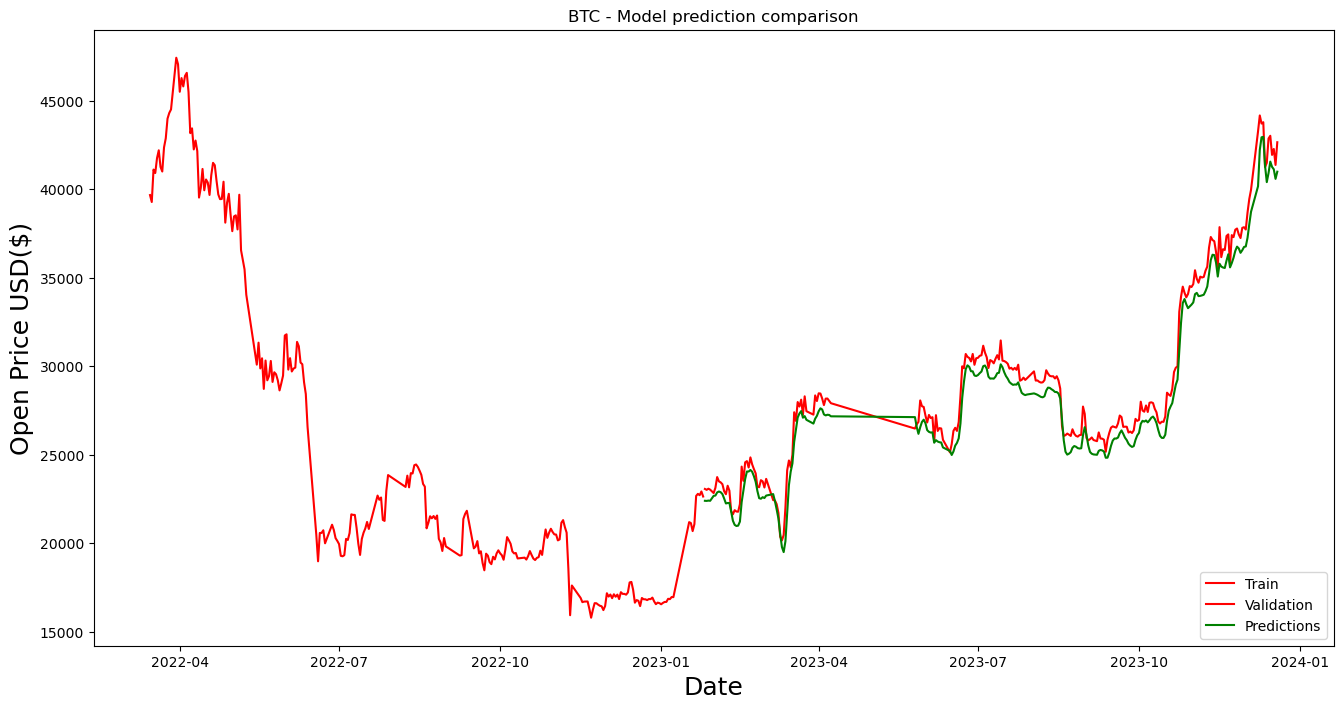

In [61]:
# Plot results
training_data_len = math.ceil(len(df)*.8)
train = df[:training_data_len]
valid = df[training_data_len:]

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
rmse = np.sqrt(mean_squared_error(valid[target_column], predictions))
print(rmse)

#plot the data
open_predictions = predictions
valid['predictions'] = open_predictions
plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Open Price USD($)', fontsize=18)
plt.plot(train[target_column][-len(valid):] , color='red')
plt.plot(valid[target_column] , color='red')
plt.plot(valid['predictions'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()                        


In [62]:
# Now, we want to check and see if the model is able to predict the DIRECTION of open accurately for each unseen day

actual = list(valid[target_column])
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(1,len(predictions)):
    prev = actual[i-1]
    today = actual[i]
    prev_pred = predictions[i-1]
    today_pred = predictions[i]
    actual_gap = today - prev
    pred_gap = today_pred - prev_pred
    if actual_gap > 0 and pred_gap > 0:
        TP += 1
    elif actual_gap < 0 and pred_gap < 0:
        TN += 1
    elif actual_gap < 0 and pred_gap > 0:
        FP += 1
    elif actual_gap > 0 and pred_gap < 0:
        FN += 1
print(len(predictions))
print(TP,TN,FP,FN)   


265
95 97 41 31


## Now, we will create another model to predict the close price

In [63]:
target_column = 'close'
target_variable = 'next_' + target_column

rmse_all, rmse_features = get_kbest_features(df, target_column)
curr_best_k = len(rmse_features[rmse_all.index(min(rmse_all))]) - 1
#model = models[rmse_all.index(min(rmse_all))]

Selected Features: ['close']
Epoch 1/50
32/32 [==============================] - 2s 18ms/step - loss: 0.0435
Epoch 2/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0057
Epoch 3/50
32/32 [==============================] - 1s 18ms/step - loss: 0.0043
Epoch 4/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0046
Epoch 5/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0041
Epoch 6/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0036
Epoch 7/50
32/32 [==============================] - 1s 25ms/step - loss: 0.0037
Epoch 8/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0035
Epoch 9/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0032
Epoch 10/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0032
Epoch 11/50
32/32 [==============================] - 1s 19ms/step - loss: 0.0035
Epoch 12/50
32/32 [==============================] - 1s 20ms/step - loss: 0.0034
Epoch 13

In [64]:
temp_df = df.copy()
temp_df[target_variable] = temp_df[target_column].shift(-1)
temp_df = temp_df.dropna() 
features = [col for col in temp_df.columns if col != target_variable]

# Split the data into features (X) and the target variable (y)
X = temp_df[features]
y = temp_df[target_variable]

# Standardize the features (important for feature selection)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Create a SelectKBest model with the desired number of top features, other than the target column (e.g., k=10)
k_best = SelectKBest(score_func=f_regression, k=curr_best_k)  
X_train_kbest = k_best.fit_transform(X_train, y_train)
X_test_kbest = k_best.transform(X_test)

# Get the indices of the selected features
selected_feature_indices = k_best.get_support(indices=True)

# Get the names of the selected features
selected_features = [features[i] for i in selected_feature_indices]

# Normalize all columns
scaler = MinMaxScaler(feature_range=(0, 1))
if target_column in selected_features:
    selected_features.remove(target_column)
selected_features.append(target_column)
print("Selected Features:", selected_features)
scaled_data = scaler.fit_transform(df[selected_features])

prices = scaled_data[:, -1]  # Extracting the normalized target column
sequence_length = 60  # Number of days to consider

training_data_len = math.ceil(len(scaled_data)*.8)
train_data = scaled_data[0:training_data_len,:]
test_data = scaled_data[training_data_len - sequence_length: , : ]

X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# Model creation
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  
model.add(LSTM(units=50))
model.add(Dropout(0.2))  
# model.add(Dense(units=25))
# model.add(Dropout(0.2))  
model.add(Dense(units=1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

model.fit(X_train, y_train, epochs=100, batch_size=32)


Selected Features: ['open', 'high', 'low', 'vwap', 'alpha42', 'close']
Epoch 1/100
32/32 [==============================] - 2s 18ms/step - loss: 0.0311
Epoch 2/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0053
Epoch 3/100
32/32 [==============================] - 1s 18ms/step - loss: 0.0044
Epoch 4/100
32/32 [==============================] - 1s 23ms/step - loss: 0.0040
Epoch 5/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0043
Epoch 6/100
32/32 [==============================] - 1s 20ms/step - loss: 0.0038
Epoch 7/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0036
Epoch 8/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0035
Epoch 9/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 10/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0034
Epoch 11/100
32/32 [==============================] - 1s 19ms/step - loss: 0.0035
Epoch 12/100
32/32 [================

9/9 [==============================] - 0s 5ms/step
884.6051822798161


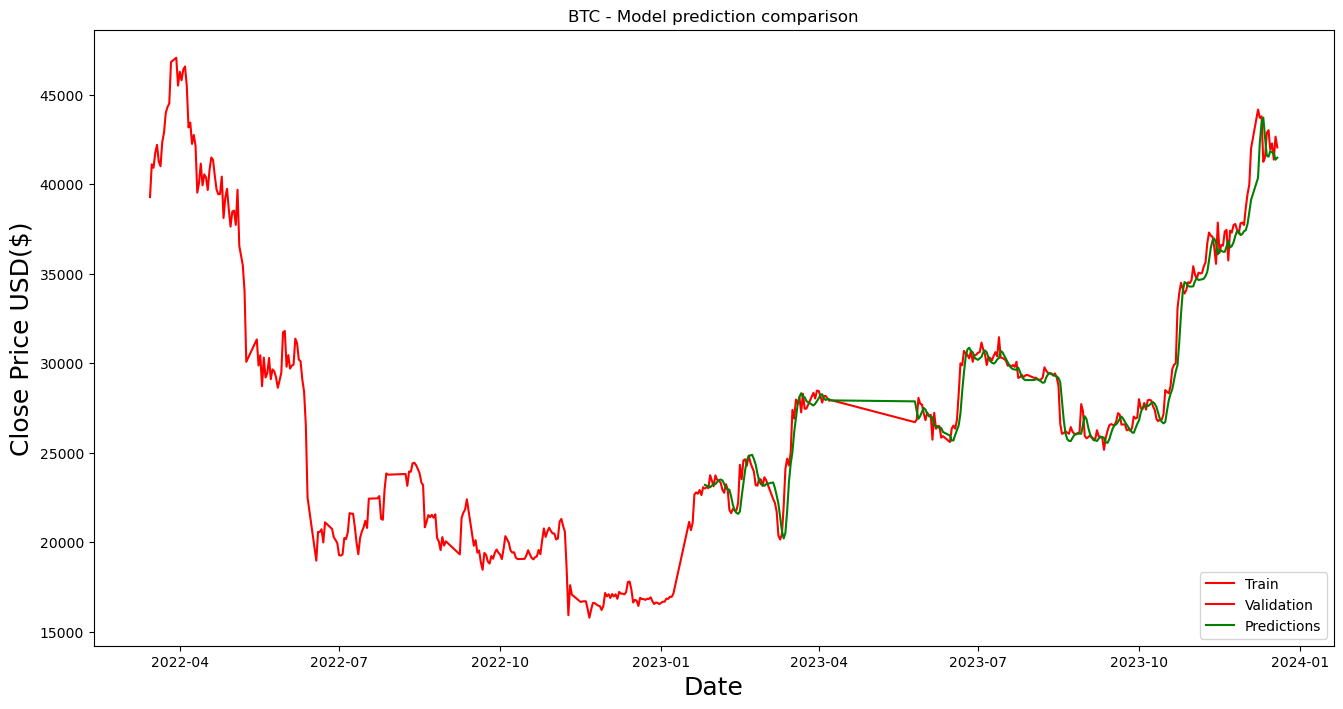

In [65]:
# Plot results
training_data_len = math.ceil(len(df)*.8)
train = df[:training_data_len]
valid = df[training_data_len:]

predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
rmse = np.sqrt(mean_squared_error(valid[target_column], predictions))
print(rmse)

#plot the data
close_predictions = predictions
valid['predictions'] = close_predictions
plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD($)', fontsize=18)
plt.plot(train[target_column][-len(valid):] , color='red')
plt.plot(valid[target_column] , color='red')
plt.plot(valid[ 'predictions'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show()                        


In [66]:
# Now, we want to check and see if the model is able to predict the DIRECTION of open accurately for each unseen day

actual = list(valid[target_column])
TP = 0
TN = 0
FP = 0
FN = 0
for i in range(1,len(predictions)):
    prev = actual[i-1]
    today = actual[i]
    prev_pred = predictions[i-1]
    today_pred = predictions[i]
    actual_gap = today - prev
    pred_gap = today_pred - prev_pred
    if actual_gap > 0 and pred_gap > 0:
        TP += 1
    elif actual_gap < 0 and pred_gap < 0:
        TN += 1
    elif actual_gap < 0 and pred_gap > 0:
        FP += 1
    elif actual_gap > 0 and pred_gap < 0:
        FN += 1
print(len(predictions))
print(TP,TN,FP,FN)   


265
56 64 73 71


## Next, we create a model to predict the daily returns

905.7416334814668


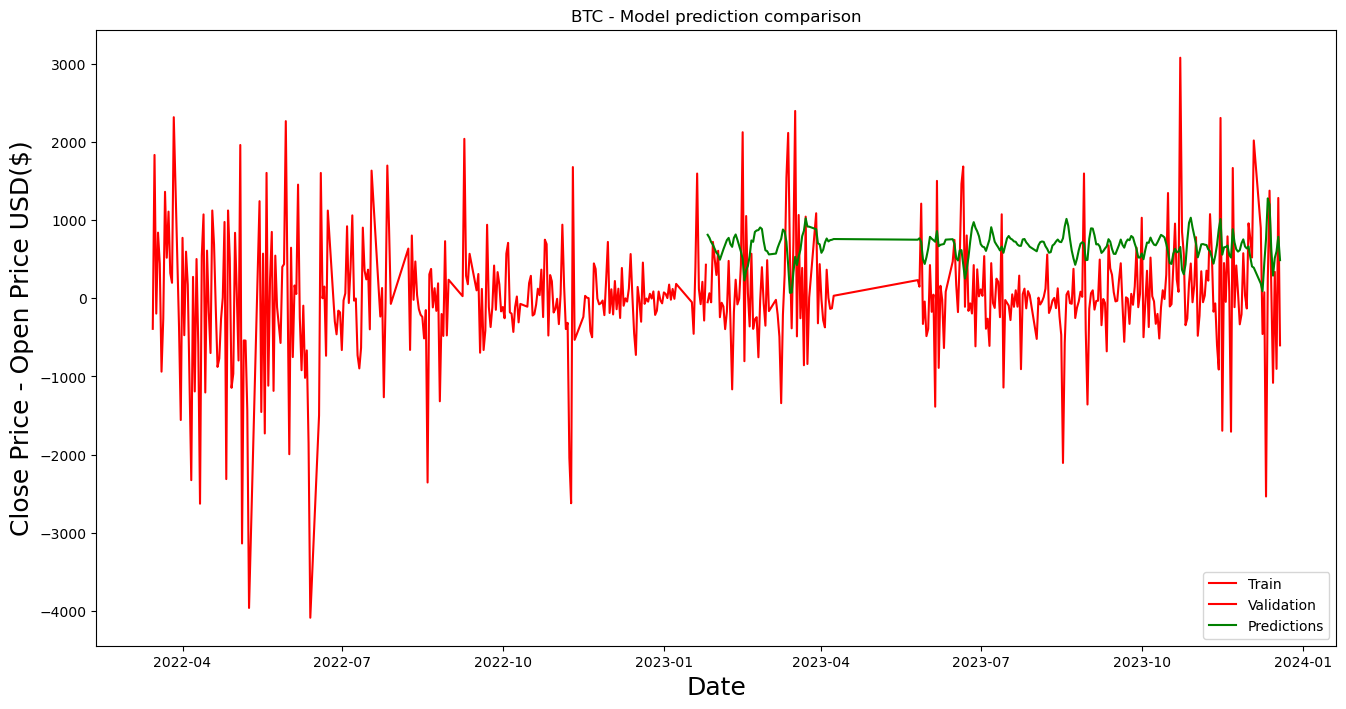

In [67]:
train = df[:training_data_len]
valid = df[training_data_len:]

# now, we calculate the close-open price everyday
train_diff = train['close'] - train['open']
valid_diff = valid['close'] - valid['open']
prediction_diff = close_predictions - open_predictions
rmse = np.sqrt(mean_squared_error(valid_diff, prediction_diff))
print(rmse)

#plot the data
train['openclose_diff'] = train_diff
valid['openclose_diff'] = valid_diff
valid['predictions_diff'] = prediction_diff

plt.figure(figsize=(16,8))
plt.title('BTC - Model prediction comparison')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price - Open Price USD($)', fontsize=18)
plt.plot(train['openclose_diff'][-len(valid):] , color='red')
plt.plot(valid['openclose_diff'] , color='red')
plt.plot(valid['predictions_diff'] , color='green')
plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
plt.show() 

In [68]:
# target_column = 'returns'
# target_variable = 'next_' + target_column

# rmse_all, rmse_features, models = get_kbest_features(df, target_column)
# curr_best_k = rmse_all.index(min(rmse_all)) + 1 # 0-index + 1
# #model = models[rmse_all.index(min(rmse_all))]

In [69]:
# temp_df = df.copy()
# temp_df[target_variable] = temp_df[target_column].shift(-1)
# temp_df = temp_df.dropna()
# features = [col for col in temp_df.columns if col != target_variable]

# # Split the data into features (X) and the target variable (y)
# X = temp_df[features]
# y = temp_df[target_variable]

# # Standardize the features (important for feature selection)
# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(X)

# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# # Create a SelectKBest model with the desired number of top features (e.g., k=10)
# k_best = SelectKBest(score_func=f_regression, k=curr_best_k)  
# X_train_kbest = k_best.fit_transform(X_train, y_train)
# X_test_kbest = k_best.transform(X_test)

# # Get the indices of the selected features
# selected_feature_indices = k_best.get_support(indices=True)

# # Get the names of the selected features
# selected_features = [features[i] for i in selected_feature_indices]
# print("Selected Features:", selected_features)

# # Normalize all columns
# scaler = MinMaxScaler(feature_range=(0, 1))
# #scaled_data = scaler.fit_transform(df[selected_features])
# scaled_data = X_scaled[:, selected_feature_indices]

# prices = X_scaled[:, list(df.columns).index(target_column)]  # Extracting the normalized 'Open' column

# sequence_length = 60  # Number of days to consider

# training_data_len = math.ceil(len(scaled_data)*.8)
# train_data = scaled_data[0:training_data_len,:]
# test_data = scaled_data[training_data_len - sequence_length: , : ]

# X_train, y_train = create_sequences(train_data, prices[0:training_data_len], sequence_length)
# X_test, y_test = create_sequences(test_data, prices[training_data_len - sequence_length:], sequence_length)

# # Model creation
# model = Sequential()
# model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))  
# model.add(LSTM(units=50))
# model.add(Dropout(0.2))  
# # model.add(Dense(units=25))
# # model.add(Dropout(0.2))  
# model.add(Dense(units=1))

# # Compile the model
# model.compile(optimizer='adam', loss='mean_squared_error')

# model.fit(X_train, y_train, epochs=100, batch_size=32)


In [70]:
# # Plot results
# training_data_len = math.ceil(len(df)*.8)
# train = df[:training_data_len]
# valid = df[training_data_len:]

# predictions = model.predict(X_test)
# predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:,0]
# rmse = np.sqrt(mean_squared_error(valid[target_column], predictions))
# print(rmse)

# #plot the data
# open_predictions = predictions
# valid['predictions'] = open_predictions
# plt.figure(figsize=(16,8))
# plt.title('BTC - Model prediction comparison')
# plt.xlabel('Date', fontsize=18)
# plt.ylabel('Returns Price USD($)', fontsize=18)
# plt.plot(train[target_column][-len(valid):] , color='red')
# plt.plot(valid[target_column] , color='red')
# plt.plot(valid[ 'predictions'] , color='green')
# plt.legend(['Train','Validation', 'Predictions'], loc='lower right')
# plt.show()                        
